## Goal:
- Build a Basic Langgraph Agent

#### imports

In [1]:
from typing import TypedDict, Annotated, Sequence
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool

from IPython.display import Image, display

import os
from dotenv import load_dotenv

In [2]:
import pkg_resources
print(pkg_resources.get_distribution("langgraph").version)

D:\Temp\ipykernel_34476\4281472091.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


0.6.8


In [3]:
load_dotenv()

True

#### AgentState

- 👉 `add_messages`: Whenever a new message is added to the state, don’t overwrite "messages". Instead, append it to the existing list.
- 👉 `Sequence`: Type hint: "messages" is a sequence (list, tuple, etc.) of `BaseMessage` objects.
- 👉 `BaseMessage`: can be `HumanMessage`, `AIMessage`, `SystemMessage`, `ToolMessage`

In [4]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

#### Define tools

In [16]:
@tool
def add(a:int, b:int):
    """ This is an addition function that adds two numbers"""
    return a + b

@tool
def sub(a:int, b:int):
    """ This is a subtraction function that subtracts two numbers"""
    return a - b

@tool
def multiply(a: int, b: int) -> int:
    """This is a multiplication function that multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

In [17]:
tools = [add, sub, multiply]

#### Define Model

In [18]:
model = ChatOpenAI(model="gpt-4o").bind_tools(tools)

In [19]:
def model_call(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content="You are my AI assistant, please answer my query to the best of your ability.")
    response = model.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

In [20]:
'''
'tool_calls': 
[{'id': 'call_yZ97kMZuNXrgpn7w1jOJwjRW', 
  'function': {'arguments': 
							'{"a":40,"b":12}', 
							'name': 'add'}, 
							'type': 'function'
			  }
]
'''
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1] ## Extracting the last AIMessage
    if not last_message.tool_calls:  
        return "end"
    else:
        return "continue"    

#### Building Graph

In [21]:
graph = StateGraph(AgentState)
graph.add_node("our_agent", model_call)
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)
graph.set_entry_point("our_agent")
graph.add_conditional_edges("our_agent",
                            should_continue,
                            {
                                "continue": "tools",
                                "end": END
                            })
graph.add_edge("tools", "our_agent")
app = graph.compile()

#### Graph Visualization

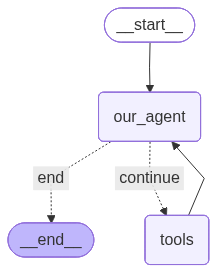

In [22]:
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
'''
param: stream is an iterator returned by app.stream(). 
So stream is not a list — it’s something you can iterate over (like reading a file line-by-line).
'''
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

#### Giving human input

In [13]:
'''
[("user", "Add 40 + 12")]

This means:
It’s a list with one message (the user’s message).
Each message tuple has two parts:
    The role — "user" (or "system", "assistant", "tool", etc.)
    The content — the text of the message ("Add 40 + 12")
'''
inputs = {"messages" : [("user", "Add 40 + 12")]}

In [23]:
print_stream(app.stream(input=inputs, stream_mode="values"))

================================ Human Message =================================

Add 40 + 12
================================== Ai Message ==================================
Tool Calls:
  add (call_42zPvd0f2zxXl6lBEiYIoeKJ)
 Call ID: call_42zPvd0f2zxXl6lBEiYIoeKJ
  Args:
    a: 40
    b: 12
================================= Tool Message =================================
Name: add

52
================================== Ai Message ==================================

The sum of 40 and 12 is 52.


In [24]:
inputs2 = {"messages" : [("user", "Multiply that by 2.")]}
print_stream(app.stream(input=inputs2, stream_mode="values"))

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

Could you please provide the number you would like to multiply by 2?


**Note**: `No memory`